In [1]:
import glob
import os
import json
import nibabel as nib
from skimage.metrics import structural_similarity as ssim
import numpy as np
import tensorflow as tf
from skimage.exposure import rescale_intensity
import pandas as pd
import datetime
import shutil

In [44]:
paths = glob.glob(r'E:\Graduation Project\FLAIR GANs Fusion\FLAIR From T1c Using GANS (SSIM + MAE) (30) - 15 June 2023_3\*')
Fusion_List = [os.path.basename(path) for path in paths]

In [45]:
# root_path = r'C:\Users\DELL\Graduation Project\Codes and Scripts\Fusion\Fusion List'
# data_list = sorted(glob.glob(root_path + '/*'))                           

# T2_sqz = r'C:\Users\DELL\Graduation Project\Codes and Scripts\Fusion\T2\sqz from t1'
# T2_unet = r'C:\Users\DELL\Graduation Project\Codes and Scripts\Fusion\T2\unet from t1'
# # FLAIR_sqz = r'C:\Users\DELL\Graduation Project\Codes and Scripts\Fusion\T1\sqz from flair'
# fusion_path = r'C:\Users\DELL\Graduation Project\Codes and Scripts\Fusion\T2\50-50 Fusion\sqz t1 + unet t1'

# sqz_data_list = sorted(glob.glob(T2_sqz + '/*'))                            
# unet_data_list = sorted(glob.glob(T2_unet + '/*'))  
# # flair_sqz_data_list = sorted(glob.glob(FLAIR_sqz + '/*'))  

In [46]:
root_path = r'E:\Graduation Project\Datasets\BraTS Validation Brain Cropped'
data_list = sorted(glob.glob(root_path + '/*'))                           
#T2_sqz->T1,      T2_Unet->T1c
'''
E:\Graduation Project\FLAIR GANs Fusion\GANS - FLAIR From T1 (SSIM) (39) - 1 June_3
E:\Graduation Project\FLAIR GANs Fusion\FLAIR From T2 Using GANS (SSIM) (46) - 1 June 2023_4
E:\Graduation Project\FLAIR GANs Fusion\FLAIR From T1c Using GANS (SSIM + MAE) (30) - 15 June 2023_3
'''
T2_sqz = r'E:\Graduation Project\FLAIR GANs Fusion\GANS - FLAIR From T1 (SSIM) (39) - 1 June_3'
T2_unet = r'E:\Graduation Project\FLAIR GANs Fusion\FLAIR From T2 Using GANS (SSIM) (46) - 1 June 2023_4'
# FLAIR_sqz = r'C:\Users\DELL\Graduation Project\Codes and Scripts\Fusion\T1\sqz from flair'
fusion_path = r'E:\Graduation Project\FLAIR GANs Fusion\50-50 T1+T2'

sqz_data_list = sorted(glob.glob(T2_sqz + '/*'))                            
unet_data_list = sorted(glob.glob(T2_unet + '/*'))  
# flair_sqz_data_list = sorted(glob.glob(FLAIR_sqz + '/*'))  

T2_SSIM_UNET = []
T2_MAE_UNET = []

T2_SSIM_SQZ = []
T2_MAE_SQZ = []

T2_MAE_FUS = []
T2_SSIM_FUS = []


T2_SQZ_PATHS = []
T2_UNET_PATHS = []
T2_T1_FUSION_PATHS = []
T1_FUSION_PATHS = []
True_paths = []

In [47]:
for dirpath, dirnames, filenames in os.walk(root_path):
    for filename in filenames:
        if filename.endswith('flair.nii.gz'):
            file_path = os.path.join(dirpath, filename)
            True_paths.append(file_path)

for dirpath, dirnames, filenames in os.walk(T2_sqz):
    for filename in filenames:
        if filename.endswith('flair.nii.gz'):
            file_path = os.path.join(dirpath, filename)
            T2_SQZ_PATHS.append(file_path)

for dirpath, dirnames, filenames in os.walk(T2_unet):
    for filename in filenames:
        if filename.endswith('flair.nii.gz'):
            file_path = os.path.join(dirpath, filename)
            T2_UNET_PATHS.append(file_path)
            
for dirpath, dirnames, filenames in os.walk(fusion_path):
    for filename in filenames:
        if filename.endswith('flair.nii.gz'):
            file_path = os.path.join(dirpath, filename)
            T1_FUSION_PATHS.append(file_path)
            os.remove(file_path)

In [48]:
print(len(T2_SQZ_PATHS), len(T2_UNET_PATHS), len(True_paths), len(T1_FUSION_PATHS))

251 251 251 251


In [49]:
T2_SQZ_PATHS[0]

'E:\\Graduation Project\\FLAIR GANs Fusion\\GANS - FLAIR From T1 (SSIM) (39) - 1 June_3\\BraTS2021_00000\\BraTS2021_00000_flair.nii.gz'

In [50]:
T1_FUSION_PATHS[0]

'E:\\Graduation Project\\FLAIR GANs Fusion\\50-50 T1+T2\\BraTS2021_00000\\BraTS2021_00000_flair.nii.gz'

In [51]:
# calculate the SSIM score for each slice of each pair of volumes
def calc_2D_tf_SSIM(Synth_paths, True_paths):
    SSIM_tf_2D = []
    for path1, path2 in zip(Synth_paths, True_paths):
        # load the volumes from files
        vol1 = nib.load(path1).get_fdata()
        vol2 = nib.load(path2).get_fdata()
        vol1 = rescale_intensity(vol1, out_range=(0, 1))
        vol2 = rescale_intensity(vol2, out_range=(0, 1))

        # calculate the SSIM score for each slice
        ssim_scores_vol = []

        for i in range(vol1.shape[2]):
            slice1 = vol1[:, :, i]
            slice2 = vol2[:, :, i]

            slice1 = np.stack([slice1]*3, axis=-1)
            slice2 = np.stack([slice2]*3, axis=-1)

            ssim_score = tf.image.ssim(slice1, slice2, max_val=1)
            ssim_scores_vol.append(ssim_score)


        # calculate the average SSIM score for the volume
        avg_ssim_vol = np.mean(ssim_scores_vol)

        # add the average SSIM scores to the list
        SSIM_tf_2D.append(avg_ssim_vol)
        
    return SSIM_tf_2D

def _calculate_mae_mse(arr1, arr2):
    diff = arr1 - arr2
    mae = np.mean(np.abs(diff))
    mse = np.mean(diff ** 2)
    return mae, mse

def calculate_mae_mse(T1_Synth_paths, T1_True_paths, norm_range):
    MAE, MSE = [], []
    for path1, path2 in zip(T1_Synth_paths, T1_True_paths):
        # load the volumes from files
        vol1 = nib.load(path1).get_fdata()
        vol2 = nib.load(path2).get_fdata()

        vol1 = rescale_intensity(vol1, out_range=norm_range)
        vol2 = rescale_intensity(vol2, out_range=norm_range)
        
        mae, mse = _calculate_mae_mse(vol1, vol2)

        MAE.append(mae)
        MSE.append(mse)
    return MAE, MSE

def psnr(Synth_paths, True_paths):
    """
    Calculate the average PSNR between corresponding slices of two 3D volumes.
    """
    PSNR = []
    for path1, path2 in zip(Synth_paths, True_paths):
        # load the volumes from files
        vol1 = nib.load(path1).get_fdata()
        vol2 = nib.load(path2).get_fdata()
        vol1 = rescale_intensity(vol1, out_range=(0, 1))
        vol2 = rescale_intensity(vol2, out_range=(0, 1))

        psnrs = []
        for i in range(vol1.shape[2]):
            mse = np.mean((vol1[:,:,i] - vol2[:,:,i]) ** 2)
            if mse == 0:
                psnrs.append(float('inf'))
            else:
                max_pixel = np.max(vol1[:,:,i])
                psnrs.append(20 * np.log10(max_pixel / np.sqrt(mse)))
        avg_psnr = np.mean(psnrs)
        PSNR.append(avg_psnr)
    return PSNR

In [52]:
def fusion(vol1_paths, vol2_paths):
    i = 0
    for path1, path2 in zip(vol1_paths, vol2_paths):
        # load the volumes from files
        x = nib.load(True_paths[i])
        vol1 = nib.load(path1).get_fdata()
        vol2 = nib.load(path2).get_fdata()
        
        # Convert the data arrays to a suitable data type for averaging
        vol1 = vol1.astype(np.float32)
        vol2 = vol2.astype(np.float32)
        
        vol1 = rescale_intensity(vol1, out_range=(0, 1))
        vol2 = rescale_intensity(vol2, out_range=(0, 1))

        vol3 = (vol1 + vol2) / 2.0
        # create a new NIfTI image object with the processed data
        nifti_image_processed = nib.Nifti1Image(vol3, x.affine, x.header)
        # save the processed NIfTI file
        nib.save(nifti_image_processed, T1_FUSION_PATHS[i])
        i = i + 1
    return vol3, nifti_image_processed
        
x, y = fusion(T2_SQZ_PATHS, T2_UNET_PATHS)

In [31]:
print(x.shape, x[50, 50, 50])

(134, 158, 135) 0.46331805


In [168]:
x4 = rescale_intensity(nib.load(T1_FUSION_PATHS[-1]).get_fdata(), out_range=(0, 1))
# x4 = nib.load(T1_FUSION_PATHS[-1]).get_fdata()
x4[50, 50, 50]

0.6544443896834787

In [53]:
T2_SSIM_SQZ = calc_2D_tf_SSIM(T2_SQZ_PATHS, True_paths)
T2_MAE_SQZ, _ = calculate_mae_mse(T2_SQZ_PATHS, True_paths, norm_range=(0, 1))

T2_SSIM_UNET = calc_2D_tf_SSIM(T2_UNET_PATHS, True_paths)
T2_MAE_UNET, _ = calculate_mae_mse(T2_UNET_PATHS, True_paths, norm_range=(0, 1))

T2_SSIM_FUS = calc_2D_tf_SSIM(T1_FUSION_PATHS, True_paths)
T2_MAE_FUS, _ = calculate_mae_mse(T1_FUSION_PATHS, True_paths, norm_range=(0, 1))

In [34]:
T2_SSIM_FUS

[0.8050813,
 0.7846613,
 0.80551934,
 0.8594283,
 0.7720702,
 0.79531324,
 0.83987534,
 0.8306146,
 0.8050048,
 0.82847303,
 0.86699635,
 0.7991777,
 0.80722725,
 0.824247,
 0.8502072,
 0.8152256,
 0.8214759,
 0.77502376,
 0.7614391,
 0.874005,
 0.81663865,
 0.8458195,
 0.7745675,
 0.8521052,
 0.83137757,
 0.7983344,
 0.8079231,
 0.82807374,
 0.8101517,
 0.8563783,
 0.8370783,
 0.73194593,
 0.80434,
 0.74808216,
 0.7429591,
 0.7450127,
 0.7956675,
 0.77746177,
 0.75050604,
 0.7832511,
 0.748017,
 0.74120235,
 0.838448,
 0.7164554,
 0.80763483,
 0.8474071,
 0.757102,
 0.72413605,
 0.8019702,
 0.75321364,
 0.8475803,
 0.7710071,
 0.75086373,
 0.7478149,
 0.74845093,
 0.76991767,
 0.8472181,
 0.79650563,
 0.78316116,
 0.80496424,
 0.7633136,
 0.7217438,
 0.7712587,
 0.7173547,
 0.7463488,
 0.7459266,
 0.70569485,
 0.7176927,
 0.73620504,
 0.78406125,
 0.791161,
 0.61875516,
 0.7899715,
 0.70091766,
 0.85311973,
 0.7962219,
 0.7828275,
 0.73600996,
 0.7730095,
 0.80349207,
 0.8144389,
 0.7

In [102]:
T2_SSIM_UNET

[0.7033953,
 0.7789829,
 0.7764957,
 0.79105186,
 0.69739544,
 0.7023732,
 0.79283625,
 0.83038586,
 0.7799731,
 0.7785825,
 0.75946087,
 0.78396595,
 0.7186521]

In [54]:
# Create a DataFrame from the lists
df = pd.DataFrame({
    "Validation Set": Fusion_List,
    'SSIM FLAIR from T1': T2_SSIM_SQZ,
    'SSIM FLAIR from T2': T2_SSIM_UNET,
    'SSIM FLAIR Fusion': T2_SSIM_FUS,

    'MAE FLAIR from T1': T2_MAE_SQZ,
    'MAE FLAIR from T2': T2_MAE_UNET,
    'MAE FLAIR Fusion': T2_MAE_FUS
})

csv_path = r'E:\Graduation Project\FLAIR GANs Fusion\FLAIR - 50-50 T1+T2.csv'
# Save the DataFrame to a CSV file
df.to_csv(csv_path, index=False)

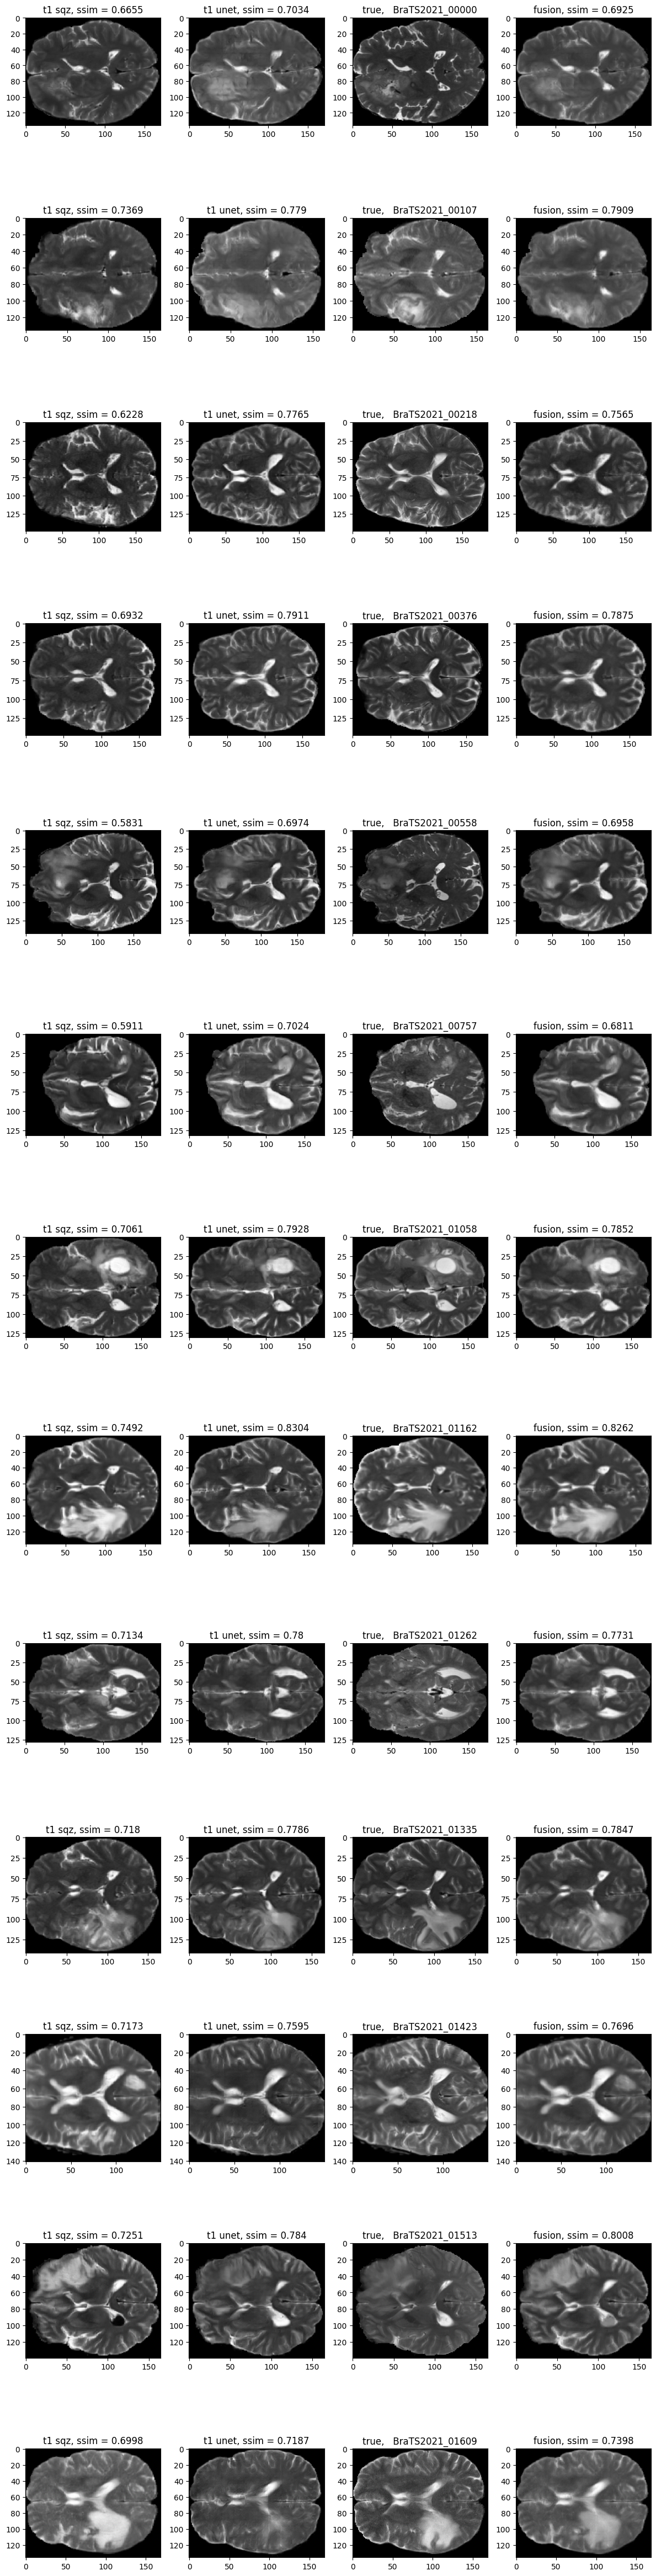

In [104]:
# T2 (UNET, SQZ) -> T1
import nibabel as nib
import matplotlib.pyplot as plt

# Assuming x1, x2, x3, x4 are the lists containing the paths

# Create a figure to display the slices
fig, axes = plt.subplots(nrows=13, ncols=4, figsize=(12, 48))

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_path)
# df = df.iloc[:, 1:]


# Iterate over the range of the length of the lists
for i in range(len(True_paths)):
    # Extract the paths from the corresponding lists
    path_x1 = True_paths[i]
    path_x2 = T2_SQZ_PATHS[i]
    path_x3 = T2_UNET_PATHS[i]
    path_x4 = T1_FUSION_PATHS[i]

    # Read the volumes using nibabel
    vol_x1 = nib.load(path_x1).get_fdata()
    vol_x2 = nib.load(path_x2).get_fdata()
    vol_x3 = nib.load(path_x3).get_fdata()
    vol_x4 = nib.load(path_x4).get_fdata()

    # Calculate the middle slice index
    middle_slice = vol_x1.shape[2] // 2

    # Display the middle slices with titles
    axes[i, 0].imshow(vol_x2[:, :, middle_slice], cmap='gray')
    axes[i, 0].set_title(f"t1 sqz, ssim = {df.iloc[i, 1]:.4}")

    axes[i, 1].imshow(vol_x3[:, :, middle_slice], cmap='gray')
    axes[i, 1].set_title(f"t1 unet, ssim = {df.iloc[i, 2]:.4}")

    axes[i, 2].imshow(vol_x1[:, :, middle_slice], cmap='gray')
    axes[i, 2].set_title(f"true,   {df.iloc[i, 0]}")

    axes[i, 3].imshow(vol_x4[:, :, middle_slice], cmap='gray')
    axes[i, 3].set_title(f"fusion, ssim = {df.iloc[i, 3]:.4}")

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()